#Library

In [160]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import warnings
import time
import psutil
import seaborn as sns
import math
from matplotlib.ticker import StrMethodFormatter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive
drive.mount('/content/drive')
warnings.simplefilter("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Fungsi Baca Data

In [161]:
def read_images_train(directory_path, percentage):
    data = []
    labels = []

    for label in os.listdir(directory_path):
        label_path = os.path.join(directory_path, label)
        images = os.listdir(label_path)
        num_images = len(images)
        num_to_read = int(num_images * percentage)

        for image_name in images[:num_to_read]:
            image_path = os.path.join(label_path, image_name)

            img = cv2.imread(image_path, 0)

            if img.shape[-1] == 3:  # Cek apakah gambar RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            data.append(img)
            labels.append(int(label))

    return np.array(data), np.array(labels)

In [162]:
def read_images(directory_path):
    data = []
    labels = []

    for label in os.listdir(directory_path):
        label_path = os.path.join(directory_path, label)

        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)

            img = cv2.imread(image_path, 0)

            if img.shape[-1] == 3:  # Cek apakah gambar RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            data.append(img)
            labels.append(int(label))

    return np.array(data), np.array(labels)

#Fungsi Baca Data (bisa milih mau ambil berapa anggota)

In [163]:
def read_images_limit(directory_path, limit_per_class=1, num_classes_for_test=40):
    data = []
    labels = []

    selected_classes = os.listdir(directory_path)[:num_classes_for_test]

    for label in selected_classes:
        label_path = os.path.join(directory_path, label)

        # Menggunakan counter untuk membatasi jumlah foto per kelas
        count = 0

        for image_name in os.listdir(label_path):
            if count >= limit_per_class:
                break

            image_path = os.path.join(label_path, image_name)

            img = cv2.imread(image_path, 0)
            data.append(img)
            labels.append(int(label))

            count += 1

    return np.array(data), np.array(labels)

#Rata-Rata Masing-Masing Kelas

In [164]:
def compute_classes_mean_matrix(train_data, train_labels):
    unique_labels = np.unique(train_labels)
    means = {}

    for label in unique_labels:
        class_images = train_data[train_labels == label]
        class_mean = np.sum(class_images, axis=0) / len(class_images)
        means[label] = class_mean

    return means

#Rata-Rata Keseluruhan Data Latih

In [165]:
def compute_overall_mean_matrix(train_data):
    total_images = len(train_data)  # Jumlah total gambar latih
    overall_mean = np.sum(train_data, axis=0) / total_images
    return overall_mean

#Matriks Persebaran Antarkelas

In [166]:
def compute_between_class_scatter_matrix(classes_means, overall_mean, train_labels):

    Sb = np.zeros((jumlah_kolom, jumlah_kolom))

    for label, class_mean in classes_means.items():
        class_images = train_data[train_labels == label]
        mean_diff = class_mean - overall_mean

        Sb += len(class_images) * np.dot(mean_diff.T, mean_diff)

    return Sb

#Matriks Persebaran Intrakelas

In [167]:
def compute_class_scatter_matrix(train_data, train_labels, classes_means):
    num_classes = len(classes_means)

    S = np.zeros((jumlah_kolom, jumlah_kolom))

    for label, class_mean in classes_means.items():
        class_images = train_data[train_labels == label]

        for image in class_images:
            Covariance = image - class_mean
            S += np.dot(Covariance.T, Covariance)

    return S

#Nilai Eigen dan Vektor Eigen

In [168]:
def compute_wmatriks(S_classes, S_between):
    # Menghitung S^(-1)WSB
    w_value = np.dot(np.linalg.inv(S_classes),S_between)
    print('Menghitung Matriks W = S^(-1)B Selesai')
    print('------------------------------------------')

    return w_value

def compute_eigen(w_value):
    # Menghitung nilai eigen dan vektor eigen
    eigenvalues, eigenvectors = np.linalg.eigh(w_value)

    return eigenvalues, eigenvectors

#Manggil Fungsi

In [169]:
if __name__ == '__main__':
    start_time = time.time()
    train_directory_path = "/content/drive/MyDrive/Colab Notebooks/2D-LDA/Training"
    test_directory_path = "/content/drive/MyDrive/Colab Notebooks/2D-LDA/Test"

    #kasih variabel

    train_data, train_labels = read_images_train(train_directory_path,1)
    print('Membaca Data Latih Selesai')
    print('------------------------------------------')

    test_data, test_labels = read_images_train(test_directory_path,1)
    print('Membaca Data Uji Selesai')
    print('------------------------------------------')

    example_image = train_data[0]
    jumlah_baris, jumlah_kolom = example_image.shape[:2]

    print('Membaca Ukuran Citra Selesai')
    print('------------------------------------------')

    classes_means = compute_classes_mean_matrix(train_data,train_labels)
    print('Menghitung Rata-Rata Masing-Masing Kelas Selesai')
    print('------------------------------------------')

    overall_mean = compute_overall_mean_matrix(train_data)
    print('Menghitung Rata-Rata Keseluruhan Data Latih Selesai')
    print('------------------------------------------')

    S_between = compute_between_class_scatter_matrix(classes_means,overall_mean,train_labels)
    print('Menghitung Matriks Persebaran Antarkelas Selesai')
    print('------------------------------------------')

    S_classes = compute_class_scatter_matrix(train_data, train_labels, classes_means)
    print('Menghitung Matriks Persebaran Intrakelas Selesai')
    print('------------------------------------------')

    w_value = compute_wmatriks(S_classes, S_between)
    print('Menghitung Matriks W = S^(-1)B Selesai')
    print('------------------------------------------')

    eigenvalues, eigenvectors = compute_eigen(w_value)
    print('Menghitung Nilai Eigen dan Vektor Eigen Selesai')
    print('------------------------------------------')

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total Waktu: {elapsed_time} detik")

    # Memeriksa penggunaan RAM
    ram_usage = psutil.virtual_memory().used
    print(f"Penggunaan RAM: {ram_usage / (1024 ** 3):.2f} GB")

Membaca Data Latih Selesai
------------------------------------------
Membaca Data Uji Selesai
------------------------------------------
Membaca Ukuran Citra Selesai
------------------------------------------
Menghitung Rata-Rata Masing-Masing Kelas Selesai
------------------------------------------
Menghitung Rata-Rata Keseluruhan Data Latih Selesai
------------------------------------------
Menghitung Matriks Persebaran Antarkelas Selesai
------------------------------------------
Menghitung Matriks Persebaran Intrakelas Selesai
------------------------------------------
Menghitung Matriks W = S^(-1)B Selesai
------------------------------------------
Menghitung Matriks W = S^(-1)B Selesai
------------------------------------------
Menghitung Nilai Eigen dan Vektor Eigen Selesai
------------------------------------------
Total Waktu: 2.219609498977661 detik
Penggunaan RAM: 1.59 GB


In [170]:
import numpy as np

def cek_definit(matriks):
    # Mengecek apakah matriks simetris
    if not np.allclose(matriks, matriks.T):
        return "Matriks tidak simetris"
    # Mengecek eigenvalue matriks
    eigenvalues = np.linalg.eigvals(matriks)
    if np.all(eigenvalues > 0):
        return "Matriks definit positif"
    elif np.all(eigenvalues < 0):
        return "Matriks definit negatif"
    elif np.all(eigenvalues >= 0):
        return "Matriks semidefinit positif"
    elif np.all(eigenvalues <= 0):
        return "Matriks semidefinit negatif"
    else:
        return "Matriks indefinit"

# Contoh penggunaan:
matriks = S_between
print(cek_definit(matriks))

Matriks definit positif


In [171]:
print(train_data[0].shape)
print(eigenvectors.shape)
print(train_data.reshape(train_data.shape[0], -1).shape)
print(np.dot(train_data,eigenvectors).shape)

(112, 92)
(92, 92)
(360, 10304)
(360, 112, 92)


#Reduksi Dimensi/Ekstraksi Fitur

In [172]:
def data_dimensionality_reduction(train_data, test_data, top_d_eigenvectors):
    train_data_dimensionally_reduced = np.dot(train_data, top_d_eigenvectors)
    test_data_dimensionally_reduced = np.dot(test_data, top_d_eigenvectors)

    i=0
    for img in train_data:
        train_data_dimensionally_reduced[i,:]=np.dot(img,top_d_eigenvectors)
        i+=1
    i=0
    for img in test_data:
        test_data_dimensionally_reduced[i,:] = np.dot(img,top_d_eigenvectors)
        i+=1

    return train_data_dimensionally_reduced,test_data_dimensionally_reduced

#Feature Extraction dan Klasifikasi dengan 1-40 Nilai Eigen Terbesar

Jumlah eigenvalue optimal adalah 10 dengan akurasi 100.00%


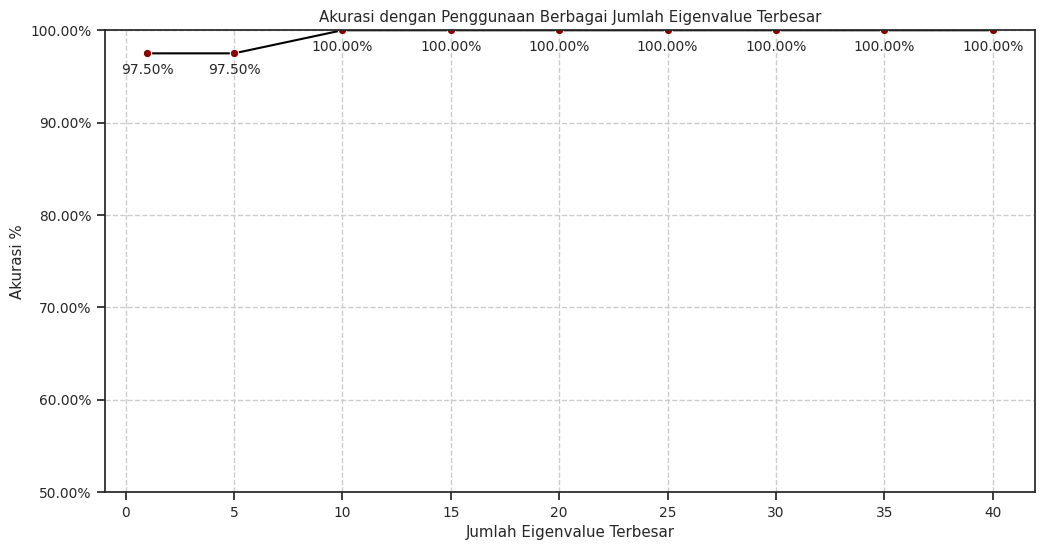

In [173]:
# Jumlah eigenvalue yang diinginkan
num_eigenvalues = [i for i in range(1, 41) if i == 1 or i % 5 == 0]

# Simpan akurasi untuk setiap jumlah eigenvalue
accuracies = []

for num_eigenvalue in num_eigenvalues:
    # Mengambil sejumlah eigenvalue terbesar
    selected_eigenvalues = eigenvalues[-num_eigenvalue:]
    selected_eigenvectors = eigenvectors[:, -num_eigenvalue:]

    # Reduksi dimensi data latih dan uji
    train_data_dimensionally_reduced, test_data_dimensionally_reduced = data_dimensionality_reduction(train_data, test_data, selected_eigenvectors)

    # Meratakan array menjadi 2D
    train_data_flat = train_data_dimensionally_reduced.reshape(train_data_dimensionally_reduced.shape[0], -1)
    test_data_flat = test_data_dimensionally_reduced.reshape(test_data_dimensionally_reduced.shape[0], -1)

    # Inisialisasi model KNN dengan k=1
    classifier = KNeighborsClassifier(n_neighbors=1)
    classifier.fit(train_data_flat, train_labels)

    # Prediksi data uji
    test_predict = classifier.predict(test_data_flat)

    # Menghitung akurasi
    accuracy = accuracy_score(test_labels, test_predict)
    accuracies.append(accuracy*100)

# Menemukan jumlah eigenvalue yang memberikan akurasi tertinggi
optimal_num_eigenvalues = num_eigenvalues[accuracies.index(max(accuracies))]

print(f"Jumlah eigenvalue optimal adalah {optimal_num_eigenvalues} dengan akurasi {max(accuracies):.2f}%")

# Plot grafik akurasi
sns.set_theme(style="ticks", font='sans-serif', palette='deep', context='notebook', font_scale=0.9)
fig, ax = plt.subplots(figsize=(12, 6))
plt.ylim(50, 100)

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}%'))

sns.lineplot(x=num_eigenvalues, y=accuracies, color='black', marker='o', markerfacecolor='darkred', ax=ax)

for i, txt in enumerate(accuracies):
    ax.annotate(f'{txt:.2f}%', (num_eigenvalues[i], accuracies[i]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=10)

ax.grid(True, linestyle='--')
ax.set(xlabel='Jumlah Eigenvalue Terbesar', ylabel='Akurasi %', title='Akurasi dengan Penggunaan Berbagai Jumlah Eigenvalue Terbesar')
plt.show()

#Tampilan Rata-Rata Kesuluruhan Data Latih

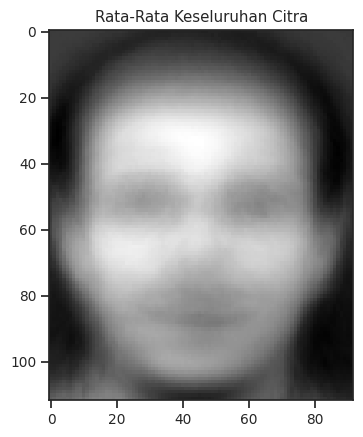

In [174]:
# Menampilkan rata-rata umum untuk semua 40 kelas
overall_mean_image = overall_mean.reshape((jumlah_baris, jumlah_kolom))  # Ubah bentuk array menjadi gambar
plt.imshow(overall_mean_image, cmap='gray')  # Menampilkan gambar dengan skala warna keabuan
plt.title('Rata-Rata Keseluruhan Citra')
plt.grid(False)
plt.show()

#Tampilan Rata-Rata Masing-Masing Kelas

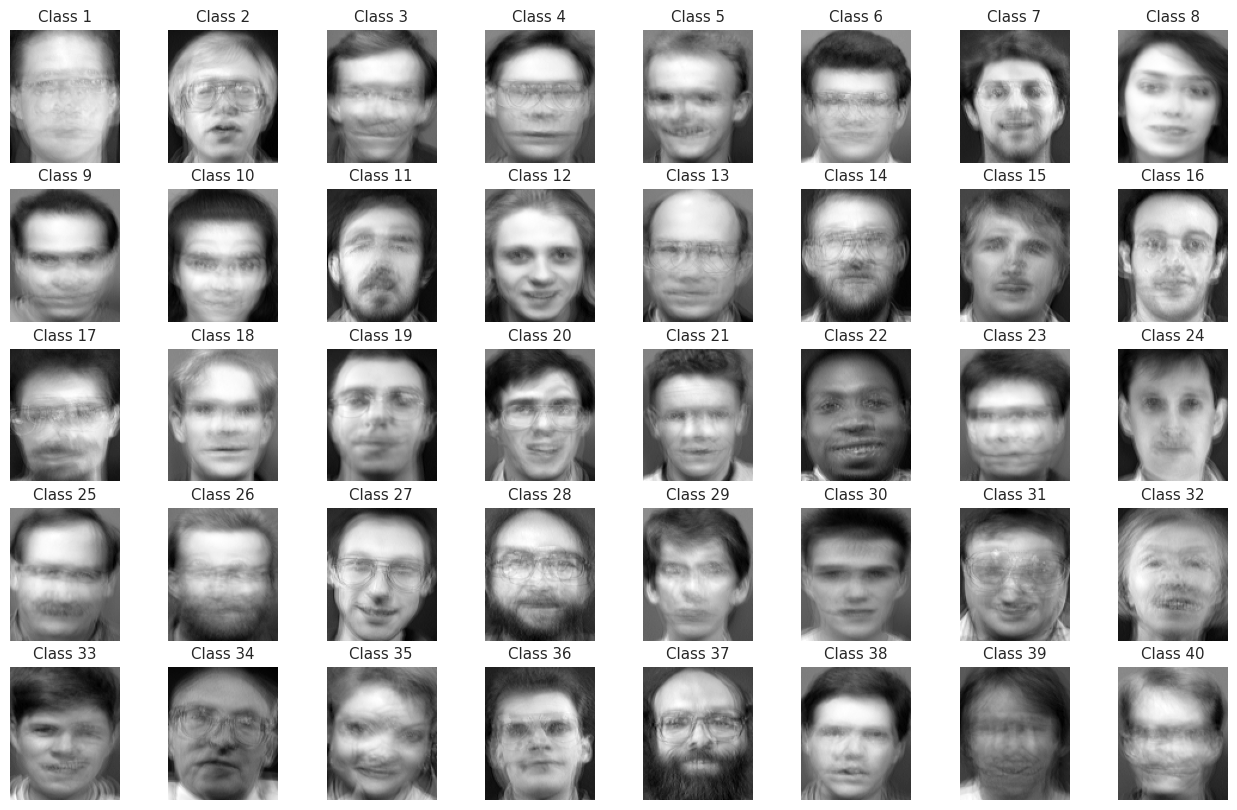

In [175]:
# Menampilkan gambar dari rata-rata setiap kelas
num_classes = len(classes_means)
num_rows = 5
num_cols = 8
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*2, num_rows*2))

for i in range(num_classes):
    class_mean_image = classes_means[i+1]
    if num_rows == 1:  # Jika hanya ada satu baris, maka axes adalah array 1D
      ax = axes[i % num_cols]
    else:  # Jika ada lebih dari satu baris, maka axes adalah array 2D
      ax = axes[i // num_cols, i % num_cols]
    ax.imshow(class_mean_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {i+1}')

plt.show()

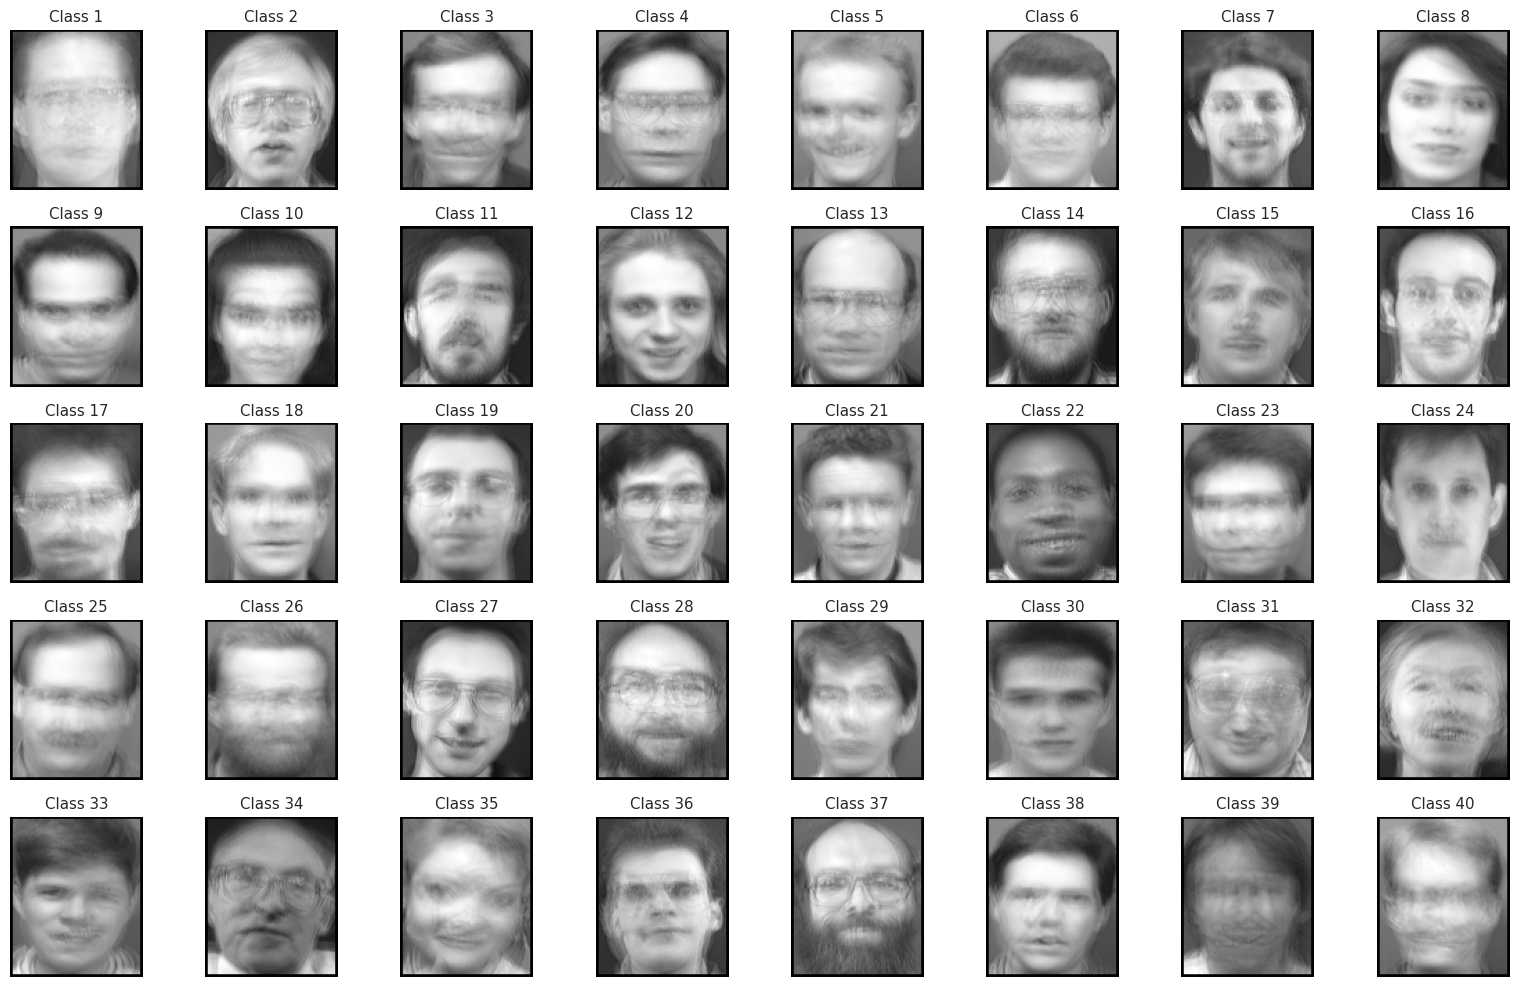

In [176]:
import matplotlib.pyplot as plt
import numpy as np

# Function to add a black border to an image
def add_border(image, border_size):
    height, width = image.shape
    bordered_image = np.zeros((height + 2 * border_size, width + 2 * border_size))
    bordered_image[border_size:border_size+height, border_size:border_size+width] = image
    return bordered_image

num_classes = len(classes_means)
num_rows = 5
num_cols = 8
border_size = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*2, num_rows*2))

for i in range(num_classes):
    class_mean_image = classes_means[i+1]
    bordered_image = add_border(class_mean_image, border_size)

    if num_rows == 1:  # If there's only one row, then axes is a 1D array
      ax = axes[i % num_cols]
    else:  # If there are multiple rows, then axes is a 2D array
      ax = axes[i // num_cols, i % num_cols]
    ax.imshow(bordered_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {i+1}')

plt.tight_layout()
plt.show()

#KNN Classifier

In [177]:
# Mengambil eigenvalue dengan akurasi yang paling besar
top_d_eigenvalues = eigenvalues[-optimal_num_eigenvalues:]
top_d_eigenvectors = eigenvectors[:, -optimal_num_eigenvalues:]

# Mengurangi dimensionalitas data latih dan uji
train_data_dimensionally_reduced, test_data_dimensionally_reduced = data_dimensionality_reduction(train_data, test_data, top_d_eigenvectors)

# Meratakan array menjadi 2D
train_data_flat = train_data_dimensionally_reduced.reshape(train_data_dimensionally_reduced.shape[0], -1)
test_data_flat = test_data_dimensionally_reduced.reshape(test_data_dimensionally_reduced.shape[0], -1)

##KNN Gapake Library

In [178]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def knn_predict(train_data, train_labels, test_instance, k=1):
    distances = [euclidean_distance(train_instance, test_instance) for train_instance in train_data]
    k_indices = np.argsort(distances)[:k]
    k_nearest_labels = [train_labels[i] for i in k_indices]
    return max(set(k_nearest_labels), key=k_nearest_labels.count)

test_predict = [knn_predict(train_data_flat, train_labels, test_instance) for test_instance in test_data_flat]

def calculate_accuracy(predicted_labels, true_labels):
    correct_predictions = sum(p == t for p, t in zip(predicted_labels, true_labels))
    return correct_predictions / len(true_labels)

# Mencetak hasil prediksi
print("Hasil Prediksi:", test_predict)

# Menghitung dan mencetak akurasi
accuracy = calculate_accuracy(test_predict, test_labels)
print("Akurasi: {:.2f}%".format(accuracy * 100))

Hasil Prediksi: [15, 14, 12, 16, 11, 17, 10, 18, 13, 1, 22, 26, 25, 27, 19, 2, 23, 21, 24, 20, 33, 35, 29, 32, 30, 34, 28, 3, 31, 36, 39, 4, 9, 5, 7, 37, 38, 6, 40, 8]
Akurasi: 100.00%


##KNN Pake Library

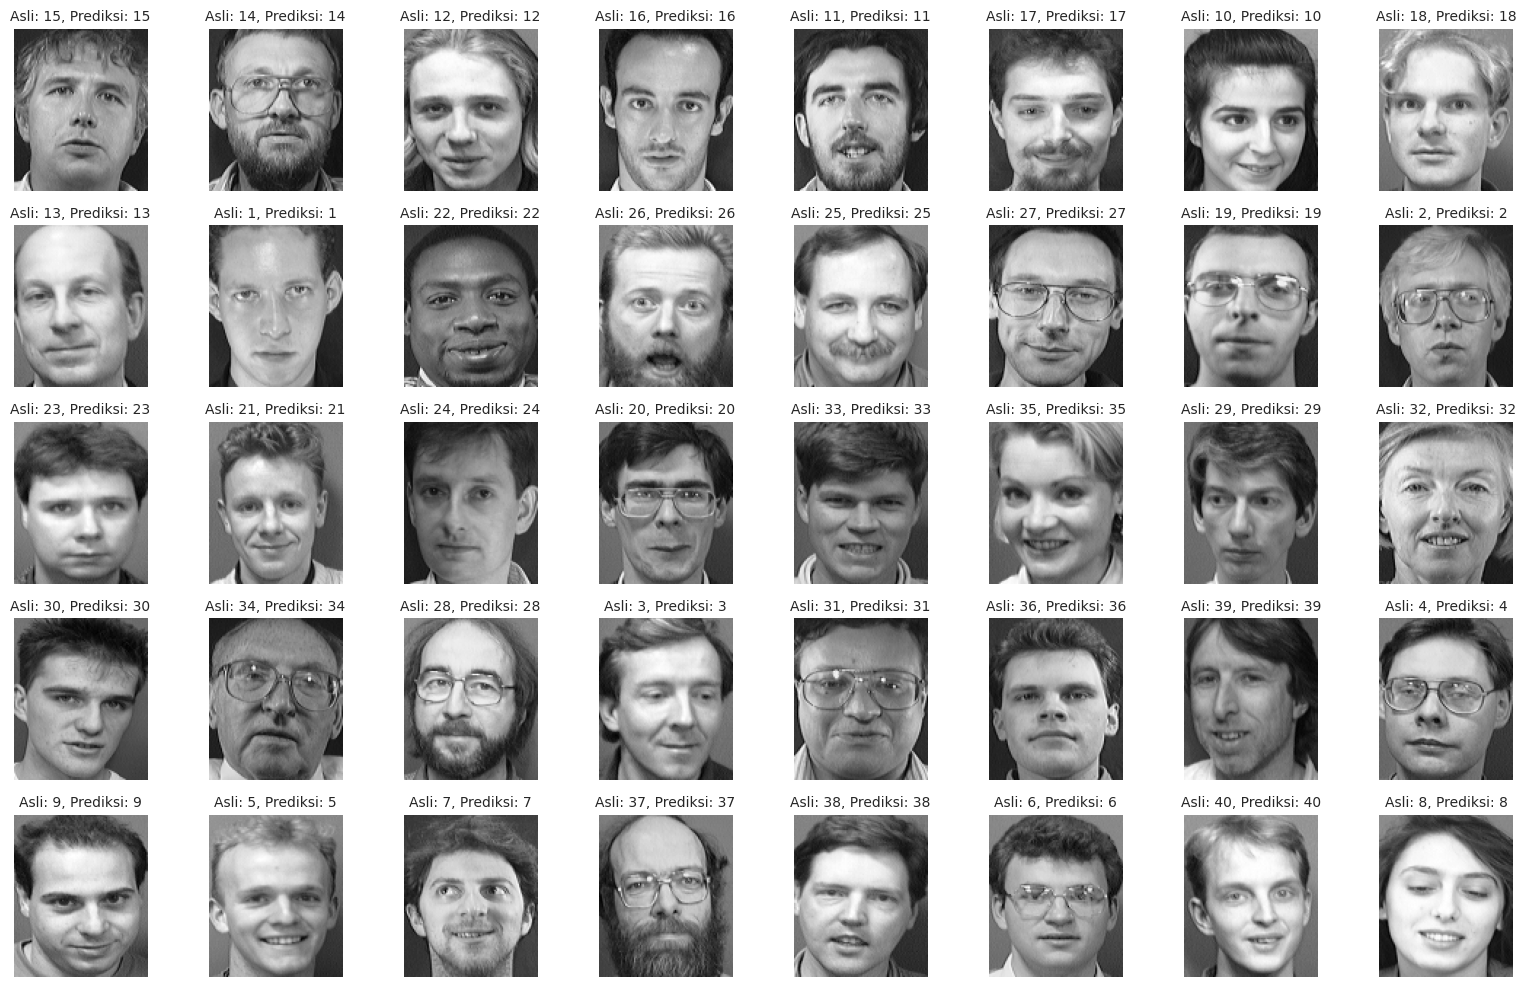

In [179]:
# Inisialisasi model KNN dengan k=1
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(train_data_flat, train_labels)

# Prediksi data uji
test_predict = classifier.predict(test_data_flat)

# Menampilkan gambar dari data uji dan label yang diperoleh setelah klasifikasi
num_images = len(test_labels)

# Menghitung jumlah baris dan kolom untuk subplot
num_rows = 5
num_cols = 8

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*2, num_rows*2))

for i in range(num_rows * num_cols):
    if axes.ndim == 1:
      ax = axes[i % num_cols]
    else:
      ax = axes[i // num_cols, i % num_cols]
    if i < num_images:  # Jika ada gambar untuk subplot ini
        img = test_data[i, :].reshape((jumlah_baris, jumlah_kolom))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if test_predict[i] != test_labels[i]:  # Periksa Klasifikasi
          ax.set_title(f'Asli: {test_labels[i]}, Prediksi: {test_predict[i]}', fontsize=10, color='red')
        else:
          ax.set_title(f'Asli: {test_labels[i]}, Prediksi: {test_predict[i]}', fontsize=10)
    else:  # Jika tidak ada gambar untuk subplot ini, sembunyikan subplot
        ax.axis('off')

fig.tight_layout(h_pad=1)
plt.show()

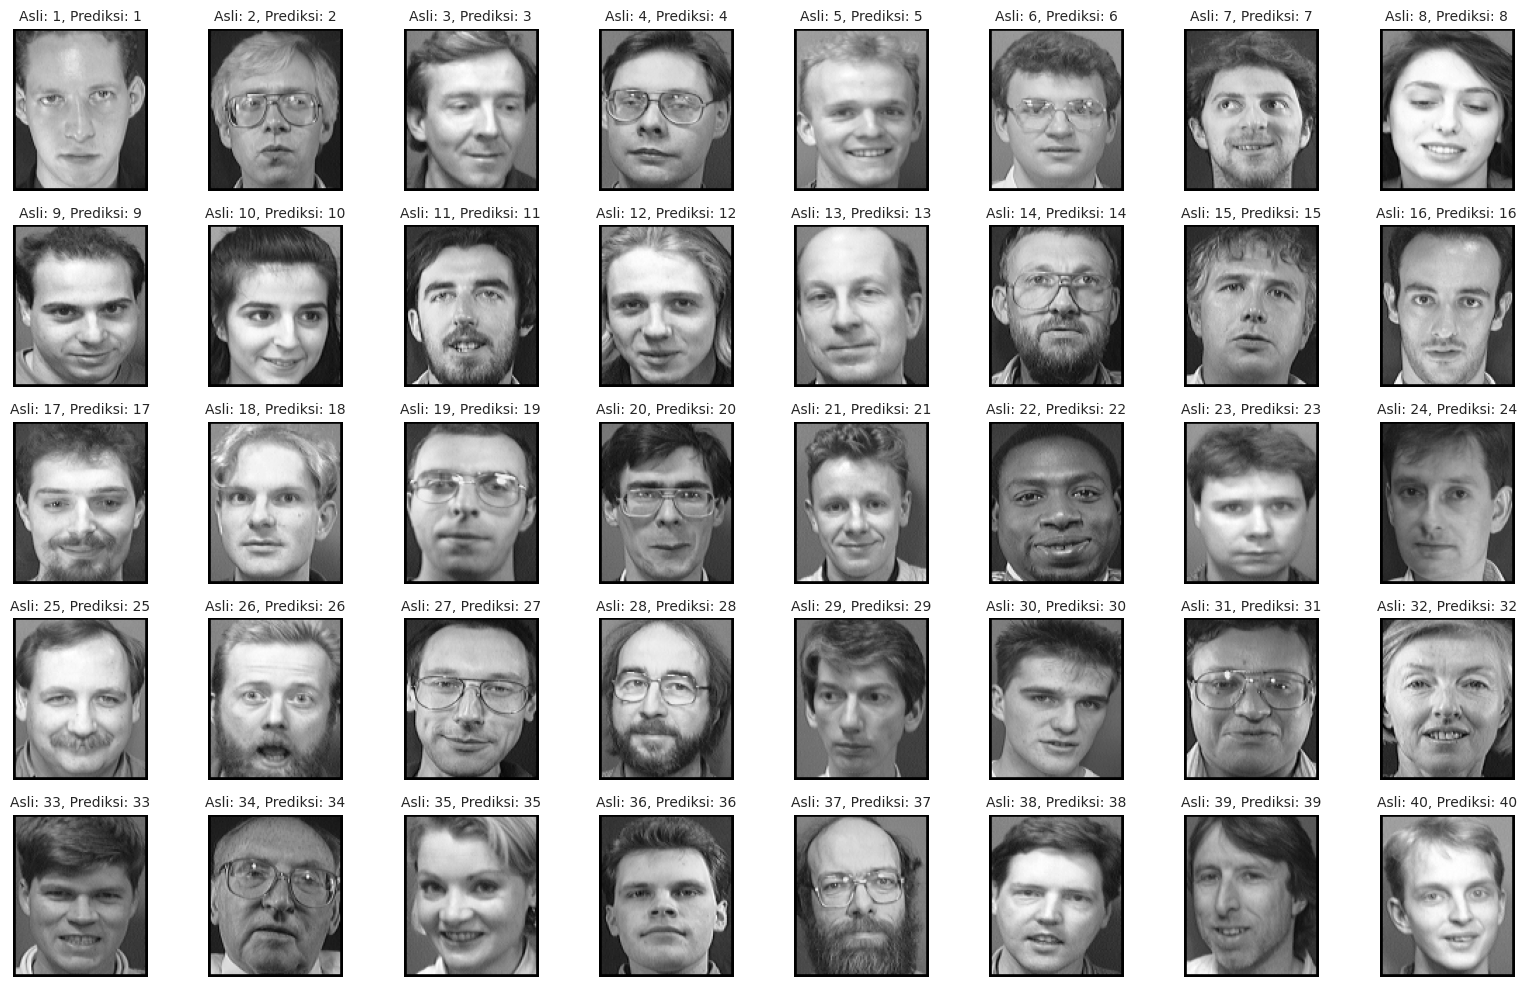

In [180]:
# Mengurutkan data uji dan label prediksi berdasarkan label kelas
sorted_indices = np.argsort(test_labels)
sorted_test_data = test_data[sorted_indices]
sorted_test_labels = test_labels[sorted_indices]
sorted_test_predict = test_predict[sorted_indices]

# Function to add a black border to an image
def add_border(image, border_size):
    height, width = image.shape
    bordered_image = np.zeros((height + 2 * border_size, width + 2 * border_size))
    bordered_image[border_size:border_size+height, border_size:border_size+width] = image
    return bordered_image

border_size = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*2, num_rows*2))

for i in range(num_images):
    if axes.ndim == 1:
      ax = axes[i % num_cols]
    else:
      ax = axes[i // num_cols, i % num_cols]

    if i < len(sorted_test_data):  # If there is an image for this subplot
        img = sorted_test_data[i, :].reshape((jumlah_baris, jumlah_kolom))
        bordered_image = add_border(img, border_size)
        ax.imshow(bordered_image, cmap='gray')
        ax.axis('off')
        if sorted_test_predict[i] != sorted_test_labels[i]:  # Check classification
            ax.set_title(f'Asli: {sorted_test_labels[i]}, Prediksi: {sorted_test_predict[i]}', fontsize=10, color='red')
        else:
            ax.set_title(f'Asli: {sorted_test_labels[i]}, Prediksi: {sorted_test_predict[i]}', fontsize=10)
    else:  # If there is no image for this subplot, hide the subplot
        ax.axis('off')

fig.tight_layout(h_pad=1)
plt.show()

#Tampilan Gambar yang Misklasifikasi

In [181]:
# Klasifikasi dengan k=1
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(train_data_flat, train_labels)
test_predict = classifier.predict(test_data_flat)

# Menghitung akurasi
accuracy = accuracy_score(test_labels, test_predict)
print(f'Akurasi untuk k=1: {accuracy * 100:.2f}%')

# Menampilkan gambar dari data uji yang salah diklasifikasi
misclassified_indices = np.where(test_predict != test_labels)[0]
num_misclassified = len(misclassified_indices)

if num_misclassified > 0:
    num_cols = min(10, num_misclassified)  # Jumlah maksimum kolom adalah 10
    num_rows = math.ceil(num_misclassified / num_cols)

    if num_misclassified == 1:
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(2, 2))
    else:
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))

    if num_rows == 1 or num_cols == 1:
        axes = np.array(axes).reshape(num_rows, num_cols)

    for i, misclassified_index in enumerate(misclassified_indices):
        img = test_data[misclassified_index, :].reshape((jumlah_baris, jumlah_kolom))  # Sesuaikan bentuk gambar dengan ukuran aslinya
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Asli: {test_labels[misclassified_index]}\nPrediksi: {test_predict[misclassified_index]}', fontsize=8, pad=8)

    plt.show()
else:
    print("Tidak ada gambar yang salah diklasifikasi.")

Akurasi untuk k=1: 100.00%
Tidak ada gambar yang salah diklasifikasi.


#Detail Penggunaan Data

In [182]:
def read_images(directory_path):
    data = []
    labels = []

    for label in os.listdir(directory_path):
        label_path = os.path.join(directory_path, label)

        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)

            # Membaca gambar
            img = cv2.imread(image_path)

            # Mengubah ke skala warna hitam putih jika gambar RGB
            if img.shape[-1] == 3:  # Cek apakah gambar RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            data.append(img)
            labels.append(int(label))

    return np.array(data), np.array(labels)

if __name__ == '__main__':
    # Informasi tentang data latih
    total_train_images = len(train_data)
    num_classes_train = len(np.unique(train_labels))
    images_per_class_train = total_train_images // num_classes_train
    image_size_train = train_data[0].shape[:2]  # Ukuran citra pertama

    # Informasi tentang data uji
    total_test_images = len(test_data)
    num_classes_test = len(np.unique(test_labels))
    images_per_class_test = total_test_images // num_classes_test
    image_size_test = test_data[0].shape[:2]  # Ukuran citra pertama

    # Informasi kombinasi data latih dan data uji
    total_images = total_train_images + total_test_images

    print(f"Jumlah total citra (latih + uji): {total_train_images} + {total_test_images} = {total_images}")
    print(f"Jumlah citra per kelas (latih): {images_per_class_train}")
    print(f"Jumlah citra per kelas (uji): {images_per_class_test}")
    print(f"Ukuran citra (latih): {image_size_train}")
    print(f"Ukuran citra (uji): {image_size_test}")
    print(f"Jumlah kelas (latih): {num_classes_train}")
    print(f"Jumlah kelas (uji): {num_classes_test}")

Jumlah total citra (latih + uji): 360 + 40 = 400
Jumlah citra per kelas (latih): 9
Jumlah citra per kelas (uji): 1
Ukuran citra (latih): (112, 92)
Ukuran citra (uji): (112, 92)
Jumlah kelas (latih): 40
Jumlah kelas (uji): 40


In [183]:
print("Train Data Shape:", train_data.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

Train Data Shape: (360, 112, 92)
Train Labels Shape: (360,)
Test Data Shape: (40, 112, 92)
Test Labels Shape: (40,)


In [184]:
print("S shape:", S_classes.shape)
print("S shape:", S_between.shape)
print(len(train_labels))

S shape: (92, 92)
S shape: (92, 92)
360


In [185]:
def count_images_per_class(train_labels):
    class_counts = np.bincount(train_labels)
    return class_counts[1:]

# Menghitung jumlah gambar per kelas
image_counts_per_class = count_images_per_class(train_labels)

# Menampilkan jumlah gambar per kelas
for label, classcount in enumerate(image_counts_per_class, start=1):
    print(f"Class {label}: {classcount} images")

Class 1: 9 images
Class 2: 9 images
Class 3: 9 images
Class 4: 9 images
Class 5: 9 images
Class 6: 9 images
Class 7: 9 images
Class 8: 9 images
Class 9: 9 images
Class 10: 9 images
Class 11: 9 images
Class 12: 9 images
Class 13: 9 images
Class 14: 9 images
Class 15: 9 images
Class 16: 9 images
Class 17: 9 images
Class 18: 9 images
Class 19: 9 images
Class 20: 9 images
Class 21: 9 images
Class 22: 9 images
Class 23: 9 images
Class 24: 9 images
Class 25: 9 images
Class 26: 9 images
Class 27: 9 images
Class 28: 9 images
Class 29: 9 images
Class 30: 9 images
Class 31: 9 images
Class 32: 9 images
Class 33: 9 images
Class 34: 9 images
Class 35: 9 images
Class 36: 9 images
Class 37: 9 images
Class 38: 9 images
Class 39: 9 images
Class 40: 9 images
